In [13]:
#Hanan Alfouzan
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()
from keras.utils.vis_utils import plot_model

In [2]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras import Sequential

In [15]:
start = dt.datetime(2020,1,1)
end = dt.datetime.now()
crypto_currency = 'BTC'
against_currency = 'USD'
local_currency= 'SAR=X'
# SAR DATA
data_local_currency = web.DataReader(local_currency, 'yahoo', start, end) 
data_local_currency = data_local_currency[['Close']]
data_local_currency = data_local_currency.rename(columns = {'Close': 'Close_SAR'})
#Bitcoin Data
data = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', start, end) 
data = data[['Close']]
data = data.rename(columns = {'Close': 'Close_BTC'})
#NVDA Data
df_NVDA=  web.DataReader('NVDA', 'yahoo', start, end) 
df_NVDA = df_NVDA[['Close']]
df_NVDA = df_NVDA.rename(columns = {'Close': 'Close_NVDA'})

#Merge Table
#data = data.merge(data_local_currency, on = 'Date')
data = data.merge(df_NVDA, on = 'Date')
data
test_data=data
test_data

,Close_BTC,Close_NVDA
Date,,
2020-01-02,6985.470215,59.977501
2020-01-03,7344.884277,59.017502
2020-01-06,7769.219238,59.264999
2020-01-07,8163.692383,59.982498
2020-01-08,8079.862793,60.095001
...,...,...
2021-11-18,56942.136719,316.750000
2021-11-19,58119.578125,329.850006
2021-11-22,56289.289062,319.559998


In [16]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data.values.reshape(-1,1))  

In [17]:
prediction_days = 60
future_day = 30

In [18]:
x_train, y_train = [], []

In [19]:
#Experimental purposes :
#for x in range(prediction_days, len(scaled_data)):
#    x_train.append(scaled_data[x-prediction_days:x, 0])
#    y_train.append(scaled_data[x, 0])

# predicting the 30th day after 60 days
for x in range(prediction_days, len(scaled_data)-future_day):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x+future_day, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [20]:
#create Neural Network 
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
27/27 [==============================] - 15s 123ms/step - loss: 0.0845
Epoch 2/25
27/27 [==============================] - 5s 204ms/step - loss: 0.0764 0s - loss: 0.0
Epoch 3/25
27/27 [==============================] - 4s 167ms/step - loss: 0.0747 0s - loss: 0.
Epoch 4/25
27/27 [==============================] - 4s 148ms/step - loss: 0.0758
Epoch 5/25
27/27 [==============================] - 4s 154ms/step - loss: 0.0745
Epoch 6/25
27/27 [==============================] - 4s 148ms/step - loss: 0.0750
Epoch 7/25
27/27 [==============================] - 4s 163ms/step - loss: 0.0765
Epoch 8/25
27/27 [==============================] - 4s 141ms/step - loss: 0.0754
Epoch 9/25
27/27 [==============================] - 4s 143ms/step - loss: 0.0750
Epoch 10/25
27/27 [==============================] - 5s 189ms/step - loss: 0.0763
Epoch 11/25
27/27 [==============================] - 5s 171ms/step - loss: 0.0762
Epoch 12/25
27/27 [==============================] - 5s 168ms/step - loss: 0.

In [22]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_3 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_4 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

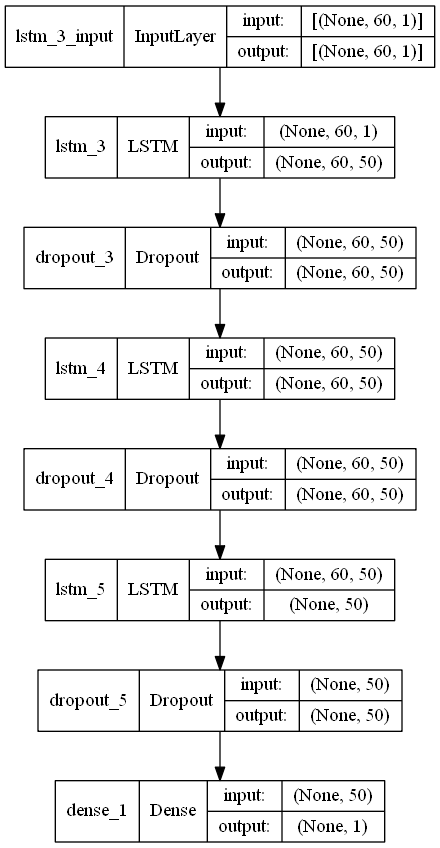

In [23]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

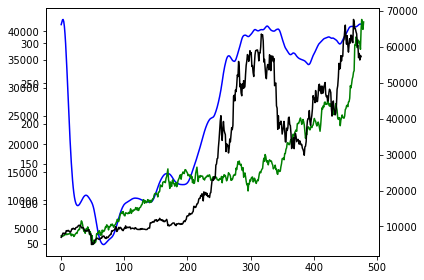

In [27]:
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()
#test_data = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', test_start, test_end)
#test_data= Above defin
actual_prices = test_data['Close_BTC'].values
total_dataset = pd.concat((data['Close_BTC'], test_data['Close_BTC']), axis=0)
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.fit_transform(model_inputs)
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

fig, ax1 = plt.subplots()

ax1.plot(prediction_prices, color='blue', label='Predicted Prices')
ax2 = ax1.twinx() 
ax2.plot(df_NVDA['Close_NVDA'].values, color='green', label='Prices')
ax3 = ax2.twinx()
ax3.plot(actual_prices, color='black', label='Actual Prices')
fig.tight_layout()
plt.show()
